# **Lab 4: Grover's Algorithm**
---

### **Description**
In this notebook, we will apply our cirq skills to implement Grover's search algorithm. **NOTE**: We really do not expect you to understand every single detail of this implementation (or any other) after just learning about this algorithm (and all of quantum computing) this weekend. Instead, we encourage you to get what you can out of this implementation and be reassured that the main focus is on *using* this algorithm.

<br>

### **Structure**
**Part 1**: [Implementing Grover's Algorithm with Cirq](#p1)

**Part 2**: [Challenge Problem](#p2)


<br>

### **Resources**
* [Cirq Basics Cheat Sheet](https://docs.google.com/document/d/1Ir1qtXS2-C_tGThk00P1fZfZjoC8oet4N9Rtkw7LgVY/edit?usp=drive_link)


<br>

**Before starting, run the code below to import all necessary functions and libraries.**


In [1]:
# Make sure to clear the kernel if you encounter an import error (Runtime -> Restart Session)
import warnings
warnings.filterwarnings("ignore")


try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    import cirq
    print("installed cirq.")

import cirq_web
import cirq_web.bloch_sphere as bloch_sphere
import matplotlib.pyplot as plt

def binary_labels(num_qubits):
    return [bin(x)[2:].zfill(num_qubits) for x in range(2 ** num_qubits)]

print("Libraries Imported Successfully!")

Libraries Imported Successfully!


<a name="p1"></a>

---
## **Part 1: Implementing Grover's Algorithm with Cirq**
---

In this section, we will see one way to implement Grover's Algorithm with Cirq. While there are many ways to do this, some of our implementation choices include:

* Searching for a bitstring out of all possible bitstrings of a given length (e.g. '101' out of '000', '001', '010', ... , '111').

* Using an extra, "ancilla", qubit that is purely for storing the phase difference between the state(s) we're looking for and the ones we're not.

#### **Problem #1.1**

To start, let's define each part of the Grover Algorithm circuit. We do not have time to dive into every detail of this right now, but nonetheless wanted to provide a quick walkthrough of how to construct each part.

##### **Step #1: Prepare equal superposition.**

The loop should hopefully be relatively straightforward; however, it's worth pointing out that we're preparing the ancilla qubit differently. In particular, we will set it to the 1 state because we will then use another gate later on, the Z gate, that flips the phase of any 1 states compared to 0 states.

In [2]:
def prepare(qubits, ancilla_qubit, circuit):

  for qubit in qubits:
    circuit.append(cirq.H(qubit))

  circuit.append(cirq.X(ancilla_qubit))

##### **Step #2: Mark states that match criteria.**

The general flow of this code is:
1. Modify the qubits so that the target bitstring is temporarily all 1s (e.g. for 3 qubits: 111).

2. Flip the phase of the ancilla qubit only if the qubits are all 1s.

3. Undo the first part so that we don't lose the original target bitstring information.

<br>

**NOTE**: This is the only part of Grover's algorithm that needs to know anything about the actual problem we're solving/item we're searching for. Constructing a *good* oracle is a difficult task, particularly in the more realistic case that we know the criteria for a solution but do not know the solutions themselves (for computer science folks, this can be thought of building our oracle as a verifier instead of a solver).

In [3]:
def oracle(qubits, ancilla_qubit, circuit, target_bitstring):

  # Create a gate that will flip the phase of the ancilla bit (with a Z gate)
  # but only if the other qubits are all 1
  phase_flip = cirq.ControlledGate(sub_gate = cirq.Z, num_controls = num_qubits)

  # Flip qubits so the target_bitstring
  # is all 1s, allowing this to control
  # a phase flip
  for i, bit in enumerate(target_bitstring):
      if bit == '0':
          circuit.append(cirq.X(qubits[i]))

  # Apply a Z gate to the ancilla qubit if all conditions are met
  # Thus marking the target_bitstring with a phase difference
  circuit.append(phase_flip(*qubits, ancilla_qubit))

  # Flip the qubits back where necessary
  # Now that the target_bitstring has been marked
  for i, bit in enumerate(target_bitstring):
      if bit == '0':
          circuit.append(cirq.X(qubits[i]))

##### **Step #3: Constructively interfere marked states, destructively interfere the rest.**

The diffusion operator is a hallmark of Grover's algorithm that doesn't care about the problem being solved at all! All it does is amplify the likelihood of measuring any states with a negative phase and decrease the likelihood of the rest.

<br>

If you are curious about more details, this [stackexchange](https://quantumcomputing.stackexchange.com/questions/13313/how-can-you-decompose-grovers-diffusion-operator-into-gates) summarizes it in gates concisely (albeit in more technical detail than we're able to cover this weekend).

In [4]:
def diffusion_operator(qubits, ancilla_qubit, circuit):

  phase_flip = cirq.ControlledGate(sub_gate = cirq.Z, num_controls = num_qubits)

  for qubit in qubits:
    circuit.append(cirq.H(qubit))
    circuit.append(cirq.X(qubit))

  circuit.append(phase_flip(*qubits, ancilla_qubit))

  for qubit in qubits:
    circuit.append(cirq.X(qubit))
    circuit.append(cirq.H(qubit))

##### **Step #4: Measure *possible* solutions.**

This should be relatively straightforward to interpret. The main thing to notice is that we don't measure the ancilla qubit. Although we could, there is no longer any meaningful information stored in it.

In [5]:
def measure_solutions(qubits, circuit):

  circuit.append(cirq.measure(qubits, key = 'solutions'))

##### **Putting it all together.**

Lastly, we can see the general flow of Grover's Algorithm by combining the parts from above.

In [6]:
def grovers_algorithm_circuit(num_qubits, target_bitstring, num_iterations):

  qubits = [cirq.NamedQubit('q' + str(i)) for i in range(num_qubits)]
  circuit = cirq.Circuit()

  ancilla_qubit = cirq.NamedQubit('ancilla')

  # Step #1
  prepare(qubits, ancilla_qubit, circuit)

  # Steps #2 - 3 repeated
  for iteration in range(num_iterations):
    oracle(qubits, ancilla_qubit, circuit, target_bitstring)
    diffusion_operator(qubits, ancilla_qubit, circuit)

  # Step #4
  measure_solutions(qubits, circuit)


  return circuit

#### **Problem #1.2**

Now, let's use our Grover's algorithm circuit to search for a specific bitstring, '101', with 1 iteration of the oracle and diffusion operator before measuring.

Circuit with 1 iterations:
ancilla: ───X───────Z───────────────Z────────────────────────────
                    │               │
q0: ────────H───────@───H───X───────@───X───H───M('solutions')───
                    │               │           │
q1: ────────H───X───@───X───H───X───@───X───H───M────────────────
                    │               │           │
q2: ────────H───────@───H───X───────@───X───H───M────────────────


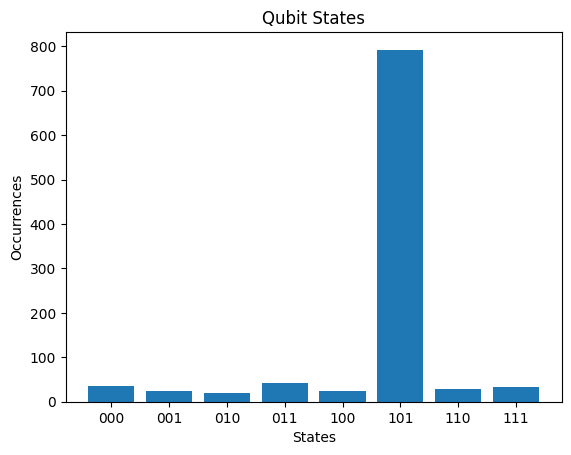

In [7]:
# Parameters
target_bitstring = '101'
num_qubits = len(target_bitstring)
num_iterations = 1

# Generate the circuit for Grover's algorithm
circuit = grovers_algorithm_circuit(num_qubits, target_bitstring, num_iterations)

# Display the circuit
print("Circuit with " + str(num_iterations) + " iterations:")
print(circuit)

# Simulate the circuit
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)

# Plot results
hist = cirq.plot_state_histogram(result, plt.subplot(), title = 'Qubit States', xlabel = 'States', ylabel = 'Occurrences', tick_label = binary_labels(num_qubits))
plt.show()

#### **Reflection**

* Did this work? How can we know?
* Can you identify each step in the circuit?

#### **Problem #1.3**

Now, let's explore the role of the number of iterations by seeing the results after running with iterations from 0 to the number of possible solutions. In general, finding the optimal number of iterations is a mix of art and science; however, if we start needing close to or more than the number of possible solutions to find the right answer then we are worse than the classical brute force search.

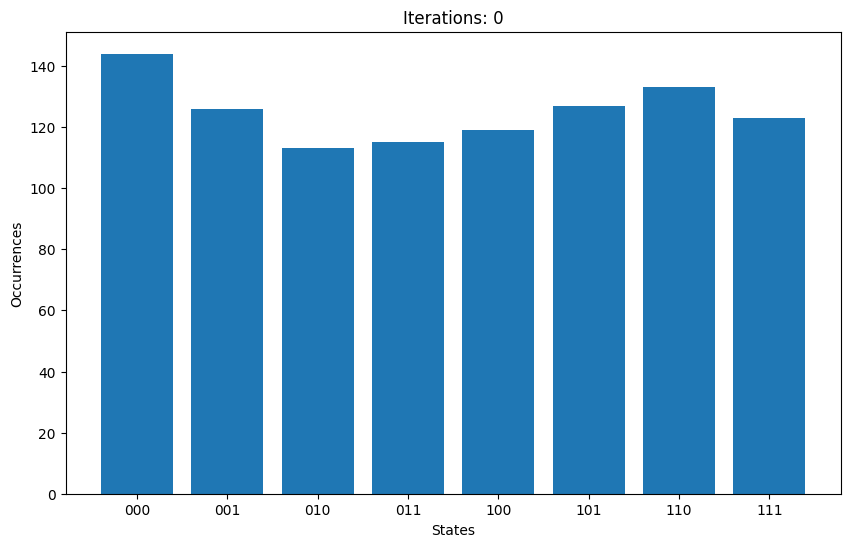

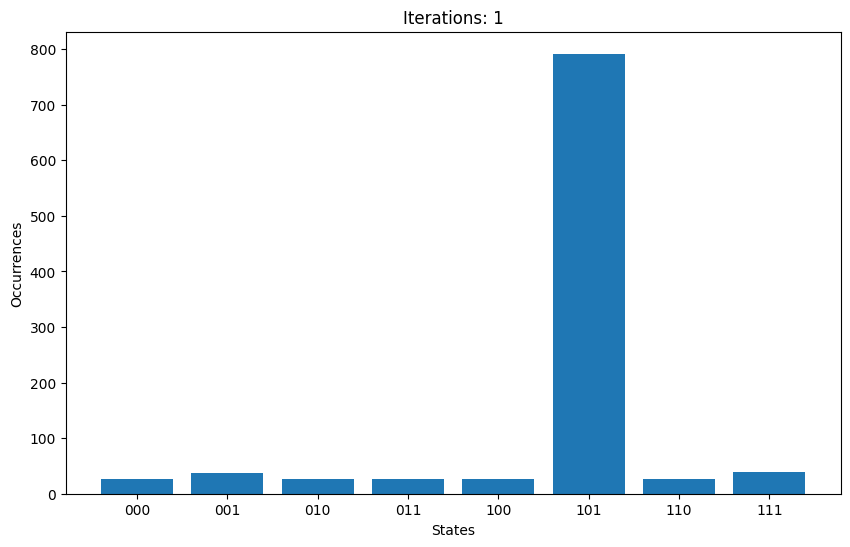

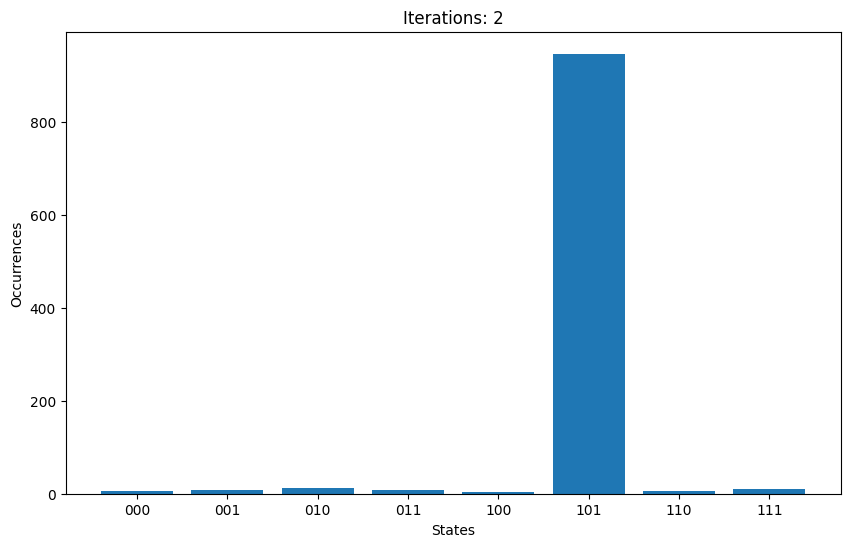

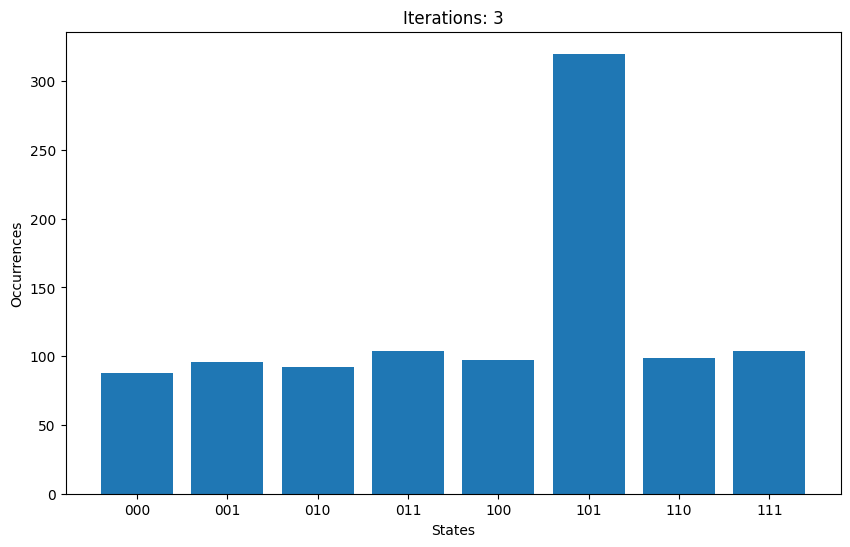

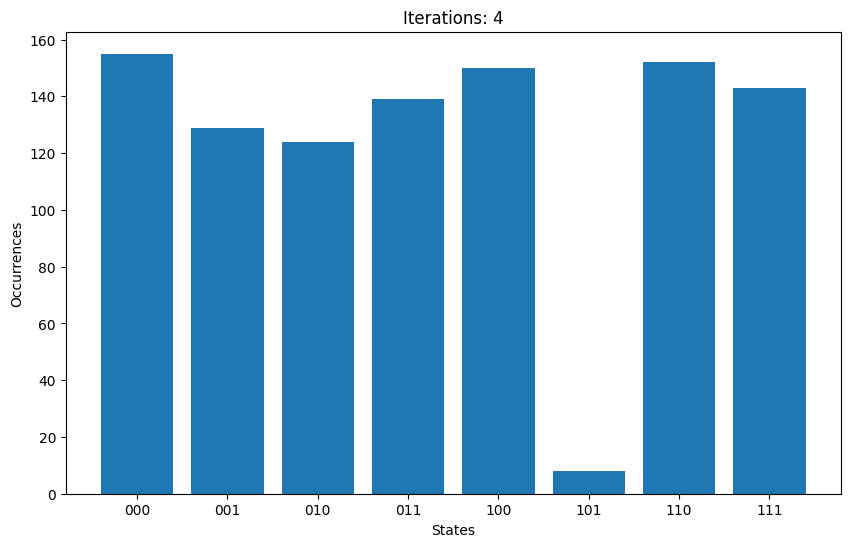

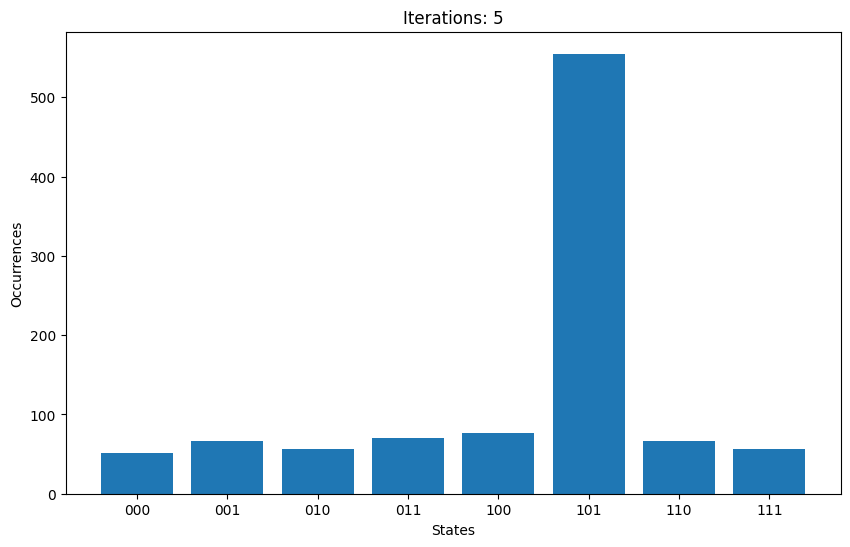

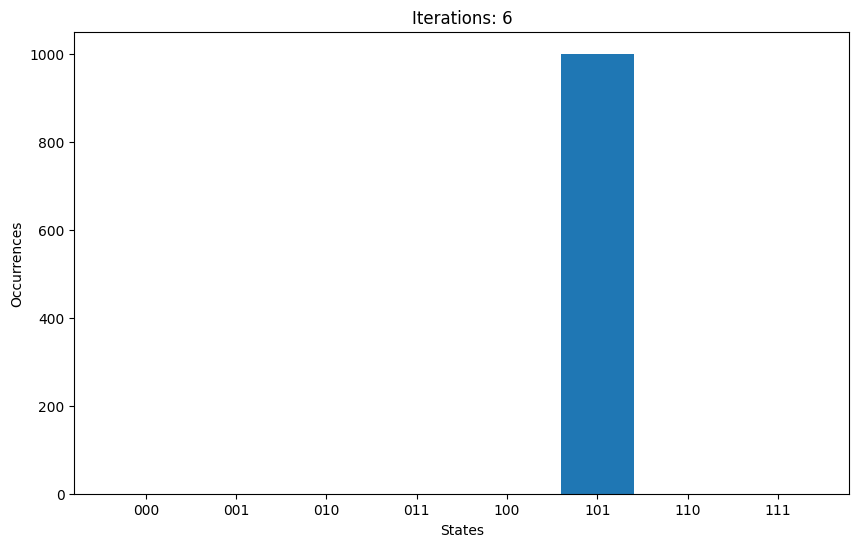

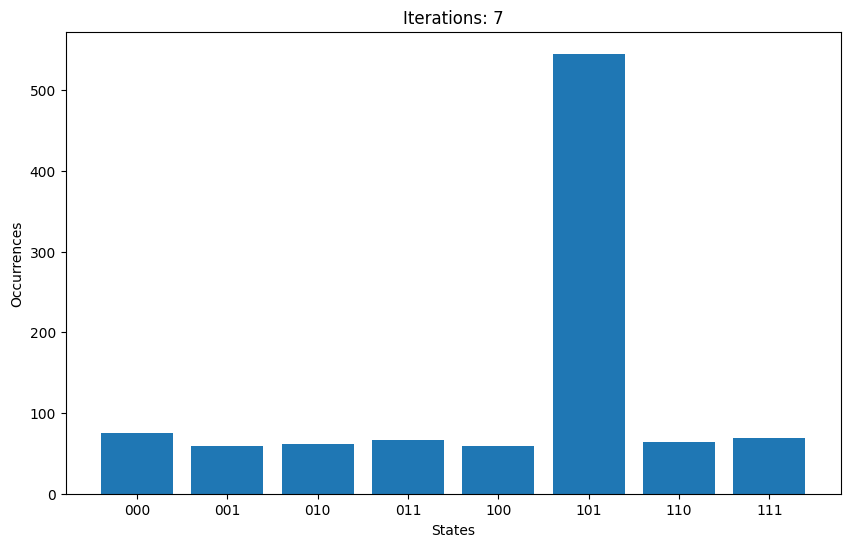

In [8]:
for num_iterations in range(2**num_qubits):
    # Generate the circuit for Grover's algorithm
    circuit = grovers_algorithm_circuit(num_qubits, target_bitstring, num_iterations)
    
    # Simulate the circuit
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=1000)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    hist = cirq.plot_state_histogram(
        result, 
        plt.subplot(), 
        title=f'Iterations: {num_iterations}', 
        xlabel='States', 
        ylabel='Occurrences', 
        tick_label=binary_labels(num_qubits)
    )
    plt.show()
    

#### **Reflection**

* The theoretical optimal number of iterations for finding one of $m$ correct items out of $n$ possibilities is $O(\sqrt{\frac{n}{m}})$. How did the results here compare?

* In the classical case, the more times you look for an item in the list, the more likely you are to find the right answer. Does this apply in the quantum case? In other words, does increasing the number of iterations always improve the probability of finding the correct answer?

The theoretical optimal number of iterations for Grover's algorithm is O(√(n/m)), which for our case with 8 possible states and 1 target state '101' calculates to approximately 2.2 iterations. Our experimental results perfectly validate this prediction, showing nearly 95% success probability at 2 iterations, closely matching the theoretical optimum.

Unlike classical search where more iterations always improve or maintain your chance of finding the correct answer, Grover's algorithm demonstrates a counterintuitive quantum mechanical property: the success probability oscillates. After reaching peak performance at 2 iterations, the probability dramatically decreased, dropping to merely 1% at 4 iterations before rising again at 5 and 7 iterations. This oscillatory behavior reveals the fundamentally different nature of quantum algorithms, where running the search process too long actually destroys the solution we're seeking.

<a name="p2"></a>

---

## **Part 2: Challenge Problem**

---

This section represents the challenge problem for this notebook that will require applying what we covered to new topics.

#### **Problem #2.1**

Your final challenge is to write a modified version of the code above that uses Grover's algorithm to search for one of *multiple* correct solutions. For example, if both '000' and '101' are equally valid solutions and we want Grover to be on the lookout for either.

<br>

To test that your code works, run the code below to see a histogram of only correct results.

In [23]:
def multi_solution_prepare(qubits, ancilla_qubit, circuit):
    for qubit in qubits:
        circuit.append(cirq.H(qubit))
    
    circuit.append(cirq.X(ancilla_qubit))
    #circuit.append(cirq.H(ancilla_qubit))


def multi_solution_oracle(qubits, ancilla_qubit, circuit, target_bitstrings):

    for target_bitstring in target_bitstrings:
        for i, bit in enumerate(target_bitstring):
            if bit == '0':
                circuit.append(cirq.X(qubits[i]))
                
        phase_flip = cirq.ControlledGate(sub_gate=cirq.Z, num_controls=len(qubits))
        circuit.append(phase_flip(*qubits, ancilla_qubit))
        
        for i, bit in enumerate(target_bitstring):
            if bit == '0':
                circuit.append(cirq.X(qubits[i]))


def multi_solution_diffusion_operator(qubits, ancilla_qubit, circuit):
    phase_flip = cirq.ControlledGate(sub_gate=cirq.Z, num_controls=len(qubits))
    
    for qubit in qubits:
        circuit.append(cirq.H(qubit))
        circuit.append(cirq.X(qubit))
    
    circuit.append(phase_flip(*qubits, ancilla_qubit))
    
    for qubit in qubits:
        circuit.append(cirq.X(qubit))
        circuit.append(cirq.H(qubit))


def multi_solution_grovers_algorithm_circuit(num_qubits, target_bitstrings, num_iterations):
    qubits = [cirq.NamedQubit('q' + str(i)) for i in range(num_qubits)]
    circuit = cirq.Circuit()
    
    ancilla_qubit = cirq.NamedQubit('ancilla')

    multi_solution_prepare(qubits, ancilla_qubit, circuit)

    for iteration in range(num_iterations):
        multi_solution_oracle(qubits, ancilla_qubit, circuit, target_bitstrings)
        multi_solution_diffusion_operator(qubits, ancilla_qubit, circuit)

    circuit.append(cirq.measure(qubits, key='solutions'))
    
    return circuit

Circuit with 1 iterations:
ancilla: ───X───────Z───────────Z───────────────Z────────────────────────────
                    │           │               │
q0: ────────H───X───@───X───────@───H───X───────@───X───H───M('solutions')───
                    │           │               │           │
q1: ────────H───X───@───X───X───@───X───H───X───@───X───H───M────────────────
                    │           │               │           │
q2: ────────H───X───@───X───────@───H───X───────@───X───H───M────────────────


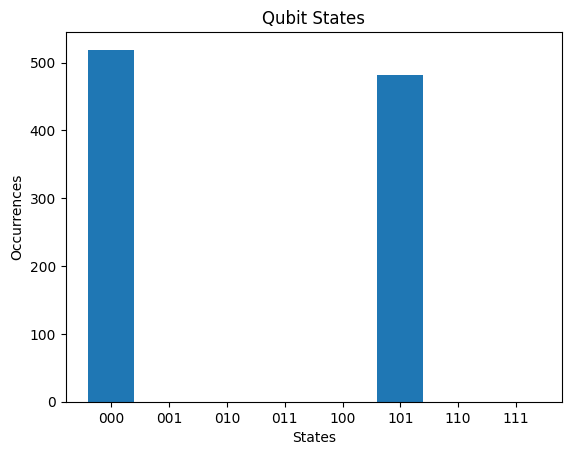

In [24]:

target_bitstrings = ['000', '101']
num_qubits = len(target_bitstrings[0])
num_iterations = 1

circuit = multi_solution_grovers_algorithm_circuit(num_qubits, target_bitstrings, num_iterations)

print("Circuit with " + str(num_iterations) + " iterations:")
print(circuit)

simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=1000)

hist = cirq.plot_state_histogram(result, plt.subplot(), title = 'Qubit States', xlabel = 'States', ylabel = 'Occurrences', tick_label = binary_labels(num_qubits))
plt.show()

#End of notebook
---
© 2024 The Coding School, All rights reserved